In [1]:
import numpy as np
import cvxpy as cp
import scipy
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from itertools import product
import warnings
import casadi as ca

# ---------------------------
# Helper functions
# ---------------------------
def default_gaussian_kernel(x, y, length_scale=0.2, variance=1.0):
    """
    Gaussian (squared exponential) kernel.
    
    Args:
        x (np.array): first input vector.
        y (np.array): second input vector.
        length_scale (float): kernel length-scale.
        variance (float): kernel variance.
        
    Returns:
        float: kernel value.
    """
    x = np.array(x)
    y = np.array(y)
    sqdist = np.sum((x - y) ** 2)
    return variance * np.exp(-0.5 * sqdist / (length_scale ** 2))


def create_uniform_grid(bounds, num_points_per_dim=10):
    """
    Creates a uniform grid (as a list of candidate points) over the domain.
    
    Args:
        bounds (list of tuples): list of (low, high) bounds for each dimension.
        num_points_per_dim (int): number of grid points per dimension.
        
    Returns:
        List[np.array]: list of candidate points.
    """
    grids = [np.linspace(b[0], b[1], num_points_per_dim) for b in bounds]
    grid_points = list(product(*grids))
    return [np.array(point) for point in grid_points]


# ---------------------------
# POPBO Class
# ---------------------------
class POPBO:
    """
    Principled Optimistic Preferential Bayesian Optimization (POP-BO)
    
    This class implements the full algorithm:
      1. Initialize with an initial point.
      2. For each iteration t:
         a. Set reference point as the previous candidate.
         b. Select a new candidate point by approximately maximizing 
            the optimistic advantage (i.e. f(x) - f(x_ref)).
         c. Query the oracle with the pair (candidate, reference) to 
            get a binary outcome.
         d. Update the maximum likelihood estimator (MLE) of the surrogate
            function based on the duel data.
      3. Report the best estimated solution.
      
    Note: All points where the function is “evaluated” (i.e. when the
    surrogate value f(x) is computed) are marked as "FUNC_EVAL POINT".
    """
    def __init__(self, config):
        """
        Initialize the POP-BO optimizer.
        
        Config parameters (with defaults):
         - x_dim: input dimension (default: 1)
         - bounds: list of (low, high) tuples for each dimension (default: [(0,1)]*x_dim)
         - kernel: a function that accepts (x, y) and returns a scalar value; 
                   default is the Gaussian kernel with length_scale=0.2.
         - kernel_params: dict for kernel parameters (e.g., {'length_scale':0.2, 'variance':1.0})
         - beta: a function of t (iteration index) used in confidence adjustment (default: lambda t: 0.1*np.sqrt(t+1))
         - oracle: a function oracle(x1, x2) that returns a binary outcome.
         - x0: initial point (np.array) to start the algorithm.
         - grid: a list of candidate points to use for candidate selection;
                   if not provided, a uniform grid over the domain is created.
         - reg: regularization weight for likelihood estimation (default: 1e-3)
         - B: bound for f(x) (default: 1.0) so that f(x) ∈ [-B, B]
         - num_grid: number of grid points per dimension if grid not provided (default: 10)
         - max_iter_estimator: maximum iterations for the MLE optimizer (default: 100)
         - epsilon: numerical stability constant (default: 1e-6)
        """
        self.x_dim = config.get('x_dim', 1)
        self.bounds = config.get('bounds', [(0, 1)] * self.x_dim)
        self.kernel_params = config.get('kernel_params', {'length_scale': 0.2, 'variance': 1.0})
        self.kernel = config.get('kernel', default_gaussian_kernel)
        self.beta = config.get('beta', lambda t: 0.1 * np.sqrt(t + 1))
        # The oracle function: expects signature oracle(x1, x2) -> {0,1}
        if 'oracle' not in config or not callable(config['oracle']):
            raise ValueError("A valid oracle function must be provided in config under 'oracle'.")
        self.oracle = config['oracle']

        self.x0 = config.get('x0')
        if self.x0 is None:
            raise ValueError("Initial point x0 must be provided in config.")
        self.x0 = np.array(self.x0)

        self.grid = config.get('grid', create_uniform_grid(self.bounds, config.get('num_grid', 10)))
        self.reg = config.get('reg', 1e-3)
        self.B = config.get('B', 1.0)
        self.max_iter_estimator = config.get('max_iter_estimator', 100)
        self.epsilon = config.get('epsilon', 1e-6)
        self.random_restarts = config.get('random_restarts', 5)
        self.solver = config.get('solver', 'ipopt')
        #used in calculating best point, essentially used to choose point with minimal uncertainty
        self.sigma_history = []
        self.estimator_history = []  # Add this in __init__

        # Data structures for storing duel data and unique points.
        # duels: list of tuples (index_candidate, index_reference, outcome)
        self.duels = []
        # data_points: list of unique points encountered (np.array)
        self.data_points = []
        # mapping: point key -> index in data_points
        self.point_index = {}

        # Initialize with initial point (both candidate and reference for first duel)
        self._add_point(self.x0)
        self.x_history = [self.x0]       # List of candidate points chosen (x_t)
        self.x_ref_history = [self.x0]     # Reference points (x'_t), initially x0
        self.outcomes = []               # Oracle outcomes (1 or 0) for each duel
        self.loglik_mle = np.inf        #log likelihood score of MLE used in surrogate function calculations

        # Maximum likelihood estimator function (f_hat) is initially a zero function.
        self.current_estimator = lambda x: 0.0
        self.exploration_rate = config.get('exploration_rate', 0)

    # --- Utility Methods ---
    def _point_to_key(self, x):
        """Helper method to convert an np.array point to a tuple key."""
        return tuple(np.round(x, decimals=8))

    def _add_point(self, x):
        """
        Add point x to the unique data_points list if not already present.
        
        Returns:
            index of x in self.data_points.
        """
        key = self._point_to_key(x)
        if key not in self.point_index:
            self.point_index[key] = len(self.data_points)
            self.data_points.append(np.array(x))
        return self.point_index[key]

    # --- Main POP-BO Algorithm Methods ---
    # ---------------------------
    # 2) Nonlinear implementation (ipopt)
    # ---------------------------

    def _select_candidate_ipopt(self, x_ref):
        """
        Nonlinear candidate selection via CasADi IPOPT.
        """
        N = len(self.data_points)
        d = self.x_dim
        X = np.array(self.data_points)
        idx_ref = self._add_point(x_ref)

        # Compute kernel matrix over data points with regularization
        K_num = np.array([
            [self.kernel(X[i], X[j], **self.kernel_params) for j in range(N)]
            for i in range(N)
        ]) + self.epsilon * np.eye(N)
        K_cas = ca.DM(K_num)  # now a CasADi constant matrix


        opti = ca.Opti()
        var_x = opti.variable(d)
        var_Z = opti.variable(N+1)

        # Objective: maximize Z[-1] - Z[idx_ref]
        opti.minimize(-(var_Z[-1] - var_Z[idx_ref]))

        # Bounds
        for k in range(d):
            opti.subject_to(var_x[k] >= self.bounds[k][0])
            opti.subject_to(var_x[k] <= self.bounds[k][1])
        opti.subject_to(var_Z >= -self.B)
        opti.subject_to(var_Z <=  self.B)

        # RKHS norm constraint
        # 5) Build symbolic k_vec and k_xx using CasADi ops
        ls = self.kernel_params.get('length_scale', 1.0)
        var = self.kernel_params.get('variance', 1.0)
        # stack k(x, X[i]) for i=0..N-1
        k_vec = ca.vertcat(*[
            var * ca.exp(-0.5 * ca.dot(var_x - ca.DM(xi), var_x - ca.DM(xi)) / (ls**2))
            for xi in X
        ])
        k_xx = var
        K_aug = ca.vertcat(
            ca.horzcat(K_cas,        k_vec),
            ca.horzcat(k_vec.T, ca.DM([[k_xx]]))
        )
        v = ca.vertcat(var_Z)
        norm_expr = v.T @ ca.solve(K_aug, v)
        opti.subject_to(norm_expr <= self.B**2)

        # Likelihood constraint
        if self.duels:
            ll = 0
            for i,j,o in self.duels:
                ll += o*(var_Z[i] - var_Z[j]) - ca.log(ca.exp(var_Z[i]) + ca.exp(var_Z[j]))
            opti.subject_to(ll >= self.loglik_mle - self.beta(len(self.duels)))

        # Initial guesses
        opti.set_initial(var_x, x_ref)
        opti.set_initial(var_Z, 0)

        # Solver
        ipopt_opts = {'print_time': False}
        ipopt_args = {
                'print_level':    0,
                'max_iter':      100,
                'tol':           1e-6,
                'acceptable_tol':1e-5,
            }
        opti.solver('ipopt', ipopt_opts, ipopt_args)
        try:
            sol = opti.solve()
            x_sol = np.array(sol.value(var_x)).flatten()
            return x_sol
        except RuntimeError as first_err:
            # save last iterate
            x_fail = opti.debug.value(var_x)
            z_fail = opti.debug.value(var_Z)
            print(f"[Warning] IPOPT first attempt failed ({first_err}). Retrying with more iterations...")

        # --- second IPOPT solve, bumping iter limit ---
        ipopt_args['max_iter'] += 100   # allow 100 more iterations
        opti.solver('ipopt', ipopt_opts, ipopt_args)
        # re‐initialize at the previous failed iterate
        opti.set_initial(var_x, x_fail)
        opti.set_initial(var_Z, z_fail)
        try:
            sol = opti.solve()
            x_sol = np.array(sol.value(var_x)).flatten()
            return x_sol
        except RuntimeError as second_err:
           print(f"[Warning] IPOPT second attempt also failed ({second_err}). Falling back to x_ref.")
           return x_ref

    def _likelihood_scalar(self, Z_vals):
        """
       Compute scalar log-likelihood from Z_vals (numpy array) using self.duels.
       """
        # No duels yet → zero log-likelihood
        if len(self.duels) == 0:
            return 0.0
        ll = 0.0
        for idx_cand, idx_ref, outcome in self.duels:
            diff = Z_vals[idx_cand] - Z_vals[idx_ref]
            # log-likelihood term: outcome*diff - log(1 + exp(diff))
            ll += outcome * diff - np.log1p(np.exp(diff))
        return ll

    def select_candidate(self, x_ref):
        """
        Select a new candidate point x by approximately maximizing 
        the optimistic advantage f(x) - f(x_ref) over the domain X.
        
        For simplicity, we use a grid search over self.grid.
        FUNC_EVAL POINT: The surrogate f_hat is evaluated at each candidate.
        
        Args:
            x_ref (np.array): The reference point (x'_t)
            f_hat (callable): The current surrogate function.
            
        Returns:
            np.array: The chosen candidate point.
        """
        if self.solver == 'convex':
            cand = self.select_candidate_convex(x_ref)
        if self.solver == 'trust-constr':
            return self._select_candidate_trust_constr(x_ref)
        elif self.solver == 'ipopt':
            return self._select_candidate_ipopt(x_ref)
        if np.allclose(cand, x_ref, atol=1e-8):
            # random exploration
            cand = np.array([np.random.uniform(lo,hi) for lo,hi in self.bounds])
            print("[Info] Tie detected; sampling random candidate for exploration.")
        return cand
    
    def update_estimator(self):
        """
        Update the maximum likelihood estimator f_hat from duel data.
        
        We formulate the following optimization problem:
        
           maximize   L(f) = sum_{duels} [ outcome * f(i) + (1-outcome)*f(j)
                      - log(exp(f(i)) + exp(f(j)) ) ]
           subject to f_i ∈ [-B, B] for each data point i,
                      plus an L2 regularization term (reg/2)*||f||^2.
        
        Here, f is a vector of function values at all unique data points
        in self.data_points.
        
        The optimal f is then used (via kernel interpolation) to create a surrogate
        function for prediction.
        
        FUNC_EVAL POINT: The surrogate f_hat is updated for all points in the dataset.
        """
        # Only update if we have at least one duel.
        if len(self.duels) == 0:
            return

        N = len(self.data_points)
        # Kernel matrix K over the data points.
        X = np.array(self.data_points)  # shape: (N, x_dim)
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                # Using provided kernel and parameters.
                K[i, j] = self.kernel(X[i], X[j],
                                      length_scale=self.kernel_params.get('length_scale', 0.2),
                                      variance=self.kernel_params.get('variance', 1.0))
        # Regularize K for inversion later.
        K += self.epsilon * np.eye(N)

        def neg_log_likelihood(f_vec):
            L = 0.0
            for (i, j, outcome) in self.duels:
                diff = f_vec[i] - f_vec[j]
                sig = 1 / (1 + np.exp(-diff))
                p = outcome * sig + (1 - outcome) * (1 - sig)
                # Add small epsilon to avoid log(0)
                L += np.log(p + 1e-9)
            reg_term = 0.5 * self.reg * np.sum(f_vec ** 2)
            return -L + reg_term


        def grad_neg_log_likelihood(f_vec):
            grad = np.zeros_like(f_vec)
            for (i, j, outcome) in self.duels:
                diff = f_vec[i] - f_vec[j]
                sig = 1 / (1 + np.exp(-diff))
                # Derivative of the likelihood wrt f_i and f_j
                dL_df = (outcome - sig)
                grad[i] -= dL_df
                grad[j] += dL_df
            grad += self.reg * f_vec
            return grad


        # Initial guess: use current estimator values at data points (or zeros)
        init_f = np.zeros(N)
        # Optionally, we can warm-start with previous f values if available.

        # Set bounds: each f_i in [-B, B]
        #bounds_f = [(-self.B, self.B)] * N
        bounds_f = [(-self.B, self.B)] * N

        # Use L-BFGS-B for optimization.
        res = minimize(neg_log_likelihood, init_f, jac=grad_neg_log_likelihood,
                       bounds=bounds_f, method='L-BFGS-B', options={'maxiter': self.max_iter_estimator})
        if not res.success:
            warnings.warn("Estimator update did not converge: " + res.message)

        f_opt = res.x  # Optimal function values at the data points
        #Store the maximum log likelihood value
        self.loglik_mle = -res.fun - (0.5*self.reg*f_opt**2).sum()  # since our objective is negative log likelihood + reg

        # Compute alpha = K^{-1} f_opt for kernel interpolation.
        alpha = np.linalg.solve(K, f_opt)

        # Define the surrogate estimator f_hat as a function:
        def f_hat(x):
            # FUNC_EVAL POINT: surrogate prediction for new x.
            x = np.array(x)
            k_vec = np.array([self.kernel(x, X[i],
                                          length_scale=self.kernel_params.get('length_scale', 0.2),
                                          variance=self.kernel_params.get('variance', 1.0)) for i in range(N)])
            return float(np.dot(k_vec, alpha))

        self.current_estimator = f_hat

    def report_best_solution(self):
        """
        Report the best candidate point.
        
        In this simple version, we return the candidate from the history
        that has the maximum estimated surrogate value f_hat.
        
        Returns:
            np.array: the reported best solution.
        """
        best_score = np.inf
        best_x = None
        for t, x in enumerate(self.x_history[1:], start=1):
            x_ref = self.x_ref_history[t]
            σ    = self.sigma_history[t-1]   # matches duel t
            score = 2 * (2*self.B + (self.epsilon)**(-0.5)*np.sqrt(self.beta(t))) * σ
            if score < best_score:
                best_score, best_x = score, x
        return best_x

    def compute_sigma_ffp(self, x, x_ref):
        """
        Compute the duel-wise uncertainty
          σ_ff'((x, x_ref))
        using the augmented kernel over all past duels.
        """
        t = len(self.duels)
        if t == 0:
            return 0.0

        # Build the t×t augmented kernel matrix K_ff′
        K = np.zeros((t, t))
        for a, (i_c, i_r, _) in enumerate(self.duels):
            xi, xri = self.data_points[i_c], self.data_points[i_r]
            for b, (j_c, j_r, _) in enumerate(self.duels):
                xj, xrj = self.data_points[j_c], self.data_points[j_r]
                K[a, b] = (
                        self.kernel(xi, xj, **self.kernel_params)
                        + self.kernel(xri, xrj, **self.kernel_params)
                )
        K += self.epsilon * np.eye(t)

        # Cross‑covariance vector between new pair and historical pairs
        kvec = np.array([
            self.kernel(self.data_points[i_c],   x,     **self.kernel_params)
            + self.kernel(self.data_points[i_r], x_ref, **self.kernel_params)
            for i_c, i_r, _ in self.duels
        ])

        # Self‑covariance of the new pair
        k00 = (
                self.kernel(x,     x,     **self.kernel_params)
                + self.kernel(x_ref, x_ref, **self.kernel_params)
        )

        # σ² = k00 − kvecᵀ K⁻¹ kvec
        v = np.linalg.solve(K, kvec)
        sigma2 = k00 - kvec.dot(v)
        return float(np.sqrt(max(sigma2, 0.0)))

    def compute_loglik(self, candidate_value, ref_value):
        """
        Compute the Bernoulli log likelihood for the new duel,
        where candidate_value is the adjusted surrogate value at the new candidate
        and ref_value is the surrogate value at the reference point.
        This implements:
            ℓ_new = log( σ(candidate_value - ref_value) )
                  = -log(1 + exp( - (candidate_value - ref_value) ) )
        Args:
            candidate_value (float): The new function value at x, i.e. f_hat(x) + z.
            ref_value (float): The fixed surrogate value at x_ref.
        Returns:
            float: Log likelihood for the duel (assuming outcome=1).
        """
        diff = candidate_value - ref_value
        return -np.log(1 + np.exp(-diff)) 

    def run(self, T=10):
        """
        Run the POP-BO algorithm for T iterations.
        
        Each iteration performs:
          - Set reference point as the previous candidate.
          - Select new candidate (via maximizing surrogate advantage).
          - Query the oracle.
          - Update the MLE estimator based on duel data.
          
        After T iterations, return the final reported best solution.
        
        Args:
            T (int): number of iterations.
            
        Returns:
            np.array: final best solution.
        """
        for t in range(1, T + 1):
            # Step 3: Set reference point x'_t = last candidate.
            if np.random.uniform(0, 1) > self.exploration_rate:
                x_ref = self.x_history[-1]
            else:
                x_ref = np.array([np.random.uniform() * (big - small) + small for (big, small) in self.bounds])
                print(x_ref, "Explored!")
                print("-" * 20)
            self.x_ref_history.append(x_ref)

            # Step 4: Select a new candidate by maximizing f(x) - f(x_ref).
            candidate = self.select_candidate(x_ref)
            self.x_history.append(candidate)

            # Step 5: Query the oracle with (candidate, reference).
            outcome = self.oracle(candidate, x_ref)
            self.outcomes.append(outcome)

            # Store duel data.
            i_candidate = self._add_point(candidate)
            i_ref = self._add_point(x_ref)
            self.duels.append((i_candidate, i_ref, outcome))

            # Highlight: these are the points where we "evaluate" the surrogate.
            # (For debugging or experimental logging, you might record candidate and x_ref evaluations.)
            print(f"Iteration {t}: Candidate = {candidate}, Reference = {x_ref}, Outcome = {outcome}")

            # Step 6: Update the estimator using all duel data.
            self.update_estimator()
            self.estimator_history.append(self.current_estimator)
            # --- compute and store duel‑wise uncertainty σ_ff′((x_t, x′_t)) ---
            sigma_t = self.compute_sigma_ffp(candidate, x_ref)
            self.sigma_history.append(sigma_t)


    # Finally, report the best solution found.
        best_sol = self.report_best_solution()
        print("Final reported best solution:", best_sol)
        return best_sol

In [2]:
# ---------------------------
# Minimal Working Example
# ---------------------------
if __name__ == "__main__":
    # Define a dummy oracle. In practice you would replace this with your own black-box oracle.
    # Here we simulate a true objective function f_true (unknown to the optimizer).
    def f_true(x):
        # FUNC_EVAL POINT: This is the true objective function (unknown to the POPBO algorithm).
        # For illustration, let f_true be a multi-dimensional quadratic function with maximum at 0.8
        x = np.array(x)
        if x.ndim != 1:
            return -np.sum((x - 0.8) ** 2, axis=1)
        else:
            return -np.sum((x - 0.8) ** 2)

    def oracle(x1, x2, det=False):
        """
        Compare two candidate points.
        Return 1 if x1 is preferred to x2, else 0.
        The probability of preferring x1 is given by the Bradley-Terry model:
           P(x1 preferred) = exp(f_true(x1)) / (exp(f_true(x1)) + exp(f_true(x2))).
        """
        p = np.exp(f_true(x1)) / (np.exp(f_true(x1)) + np.exp(f_true(x2)))
        if det:
            observation = p > 0.5
        else:
            observation = p > np.random.uniform()
        # For a deterministic outcome (for testing), choose 1 if p > 0.5.
        return observation
    
    def embed(x):
        pass #TODO embedding of input points into preference space
    
    def oracle2(x1, x2, det=False):
        embed_1 = embed(x1)
        embed_2 = embed(x2)
        norm = (embed_1 @ np.array([x1, 1])) @ embed_2
        p = 1 / (1 + np.exp(-norm))
        if det:
            observation = p > 0.5
        else:
            observation = p > np.random.uniform()
        return observation

    # Configuration for POPBO.
    config = {
        'x_dim': 2,                               # 2D problem
        'bounds': [(0, 1), (0, 1)],                # default domain is [0,1]^2
        'kernel_params': {'length_scale': 0.1, 'variance': 1.0},
        'kernel': default_gaussian_kernel,         # use default Gaussian kernel
        'beta': lambda t: 0.1 * np.sqrt(t + 1),      # beta function (not used explicitly in this simplified version)
        'oracle': oracle,                          # our dummy oracle function
        'x0': np.array([0.4, 0.4]),                  # initial point in the middle of [0,1]^2
        'num_grid': 20,                            # use 20 points per dimension in the grid
        'reg': 1e-2,
        'B': 8.0,
        'max_iter_estimator': 10,
        'epsilon': 1e-6,
        'exploration_rate': 0.,
        'solver': 'ipopt',
        'random_restarts': 2
    }

    # Initialize and run POPBO for a fixed number of iterations.
    popbo = POPBO(config)
    final_solution = popbo.run(T=60)

    print("Final solution (as estimated by POPBO):", final_solution)
    print("Function value (as estimated by POPBO):", popbo.current_estimator(final_solution))
    print("True function value at final solution (unknown to algorithm):", f_true(final_solution))



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Iteration 1: Candidate = [0.83573738 0.83573738], Reference = [0.4 0.4], Outcome = False
Iteration 2: Candidate = [0.15597877 0.15597877], Reference = [0.83573738 0.83573738], Outcome = False
Iteration 3: Candidate = [1.21312687e-09 1.21312687e-09], Reference = [0.15597877 0.15597877], Outcome = True
Iteration 4: Candidate = [5.70336242e-09 8.50661499e-01], Reference = [1.21312687e-09 1.21312687e-09], Outcome = True
Iteration 5: Candidate = [0.91284496 0.1510861 ], Reference = [5.70336242e-09 8.50661499e-01], Outcome = False
Iteration 6: Candidate = [0.41269662 0.99947312], Reference = [0.91284496 0.151086

/var/folders/vk/38fbwqvx4dg05k8q97qj8qfm0000gn/T/ipykernel_43129/43232123.py:365: UserWarning: Estimator update did not converge: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  warnings.warn("Estimator update did not converge: " + res.message)


Iteration 8: Candidate = [8.01060838e-06 5.14058993e-01], Reference = [0.74393217 0.48517506], Outcome = False
Iteration 9: Candidate = [5.43170829e-01 2.36801530e-05], Reference = [8.01060838e-06 5.14058993e-01], Outcome = True
Iteration 10: Candidate = [0.5048622  0.68205805], Reference = [5.43170829e-01 2.36801530e-05], Outcome = True
Iteration 11: Candidate = [0.6381166  0.27042148], Reference = [0.5048622  0.68205805], Outcome = False
Iteration 12: Candidate = [0.2291418  0.73069931], Reference = [0.6381166  0.27042148], Outcome = True
Iteration 13: Candidate = [4.48917730e-10 7.14774945e-01], Reference = [0.2291418  0.73069931], Outcome = True
Iteration 14: Candidate = [0.99999987 0.99999987], Reference = [4.48917730e-10 7.14774945e-01], Outcome = True
Iteration 15: Candidate = [0.39399647 0.17071392], Reference = [0.99999987 0.99999987], Outcome = False
Iteration 16: Candidate = [0.999999   0.52114321], Reference = [0.39399647 0.17071392], Outcome = True
Iteration 17: Candidate 

In [3]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)
grid = np.stack([m.flatten() for m in (X, Y)]).T
function_plot = f_true(grid).reshape(X.shape)
estimated_grid = list()
for grid_elem in grid:
    estimated_grid.append(popbo.current_estimator(grid_elem))
estimated_grid = np.array(estimated_grid).reshape(X.shape)

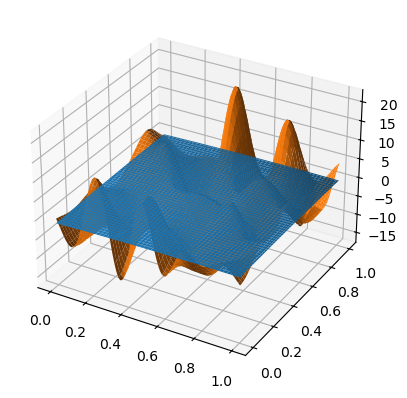

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim(-2, 2)
surf = ax.plot_surface(X, Y, function_plot)
surf2 = ax.plot_surface(X, Y, estimated_grid)

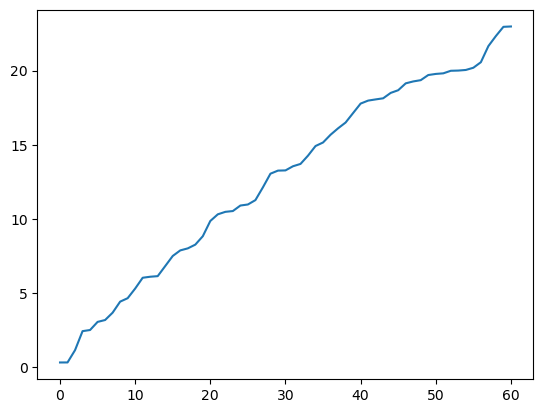

In [235]:
x_hist = np.array(popbo.x_history)
vals_found = f_true(x_hist)
plt.plot(-(vals_found.cumsum()))

In [236]:
x1, x2 = 10, 2
norm = (np.array([[0,-1], [1,0]]) @ np.array([x1, 1])) @ np.array([x2, 1])
p = 1 / (1 + np.exp(-norm))
p
np.max(vals_found)

-0.002554320671317601

In [237]:
vals_found[vals_found >= -0.01]

array([-0.00255432])

In [298]:
X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)
grid = np.stack([m.flatten() for m in (X, Y)]).T
function_plot = f_true(grid).reshape(X.shape)
grids = [[estimator(grid_elem) for grid_elem in grid]for estimator in popbo.estimator_history]
regret_hist = np.abs((0 - vals_found)).cumsum()
x_hist = np.vstack([np.array(popbo.x_history).T, x_values]).T

array([ 0.83573738,  0.83573738, -0.00255432])

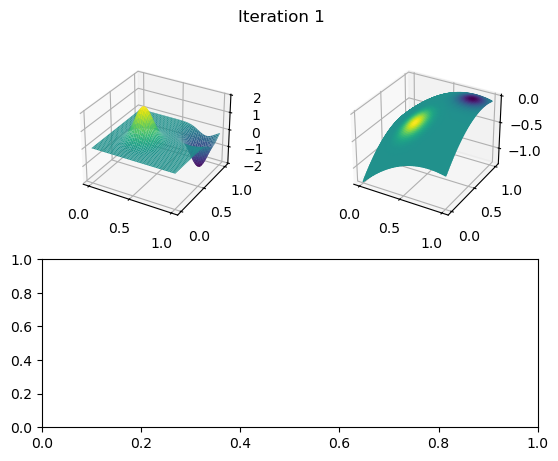

In [321]:
def animate_mle_evolution(popbo):
    if popbo.x_dim == 1:
        fig = plt.figure(figsize=(5, 10))
        ax = fig.add_subplot(121)
        err = fig.add_subplot(221)
        line, = ax.plot([], [], lw=2)
        err_line, = err.plot([], [], lw=2)
        ax.set_xlim(popbo.bounds[0])
        ax.set_ylim(-popbo.B, popbo.B)

        def update(frame):
            estimated_grid = np.array(grids[frame]).reshape(X.shape)
            line.set_data(X, estimated_grid)
            err_line.set_data(range(frame), regret_hist[:frame])
            fig.suptitle(f"Iteration {frame+1}")
            return line, err_line

    elif popbo.x_dim == 2:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(221, projection='3d')
        func_plot = fig.add_subplot(222, projection='3d')
        err = fig.add_subplot(2,2,(3,4))
        Z = np.zeros_like(X)
        surf = [ax.plot_surface(X, Y, Z, cmap='viridis')]
        func_plot.set_xlim(popbo.bounds[0][0])
        func_plot.set_ylim(popbo.bounds[0][1])
        func_surf = func_plot.plot([], [], [])
        err_line, = err.plot([], [], lw=2)

        def update(frame):
            estimated_grid = np.array(grids[frame]).reshape(X.shape)
            ax.clear()
            ax.plot_surface(X, Y, estimated_grid, cmap='viridis')
            func_plot.clear()
            normed_vals = (estimated_grid - estimated_grid.min()) / (estimated_grid.max() - estimated_grid.min() + 1e-8)
            #facecolors = cm.viridis(normed_vals)
            # Generate facecolors using the colormap
            facecolors = plt.cm.viridis(normed_vals)
            # Adjust facecolors dimensions to match plot_surface expectations
            facecolors = facecolors[:-1, :-1, :]  # Shape (n-1, m-1, 4)

            # Plot the surface with function_plot as Z and facecolors from normed_vals
            func_plot.plot_surface(X, Y, function_plot, facecolors=facecolors, shade=False)
            func_plot.scatter(x_hist[:frame,0],x_hist[:frame, 1], x_hist[:frame, 2] , c='red')
            err.set_xlim(0, frame if frame > 1 else 1)
            err.set_ylim(0, max(regret_hist[:frame]) * 1.1 if frame > 0 else 1.0)
            err_line.set_data(range(frame), regret_hist[:frame])
            fig.suptitle(f"Iteration {frame+1}")
            

    else:
        raise NotImplementedError("Animation is supported for 1D and 2D only.")
    num_frames = len(popbo.estimator_history)-1
    return FuncAnimation(fig, update, frames=num_frames, interval=500, repeat=False)

# Usage after training
ani = animate_mle_evolution(popbo)

In [322]:
ani.save("figures/POPBO/quadTestevo.gif",writer="pillow", fps=5)